This lecture explores a potential inequity, much like you are expected to do on [Assignment 1](https://afraenkel.github.io/fairness-algo-decision/assignments/inequity-analysis/). Specifically, I want to consider the extent to which inequities exist in public high school in New York City.  My goal today is to address how aggregate educational outcomes vary by socioeconomic status

Before beginning, it helps to review the five components this assignment that we are aiming to address: 

Component | Description
:-------: | :----------
1 <a class="anchor" id="c1"></a> | An introduction to the problem and the main conclusion of the paper. |
2 <a class="anchor" id="c2"></a> | A description of the historical/sociological/economic context of the studied inequity, as well as a description of the inequity itself. This section should put the inequity in the context of the qualitative theories of justice, equality, and power structures covered in class.
3 <a class="anchor" id="c3"></a> | A description of the observed data and in what ways it is appropriate for investigating the inequity at hand, and in what ways it *fails* to capture needed information for your study (making reference to material on measurement and power in week 2). This portion with be backed by data.
4 <a class="anchor" id="c4"></a> | A description of the quantitative measures of fairness that you used in your investigation, why they are appropriate for the given context, alongside the results of those calculations.
5 <a class="anchor" id="c5"></a> | An interpretation of the results from (4), including informal reasoning of the cause of the inequities. If appropriate, you can discuss possible reasons your results don't represent the inequity in a straightforward way (e.g. under/over represents it). Be specific about the limitations of your approach.
   
I'll be referring to these five elements throughout today's lecture.

# Data 

I will primarily be using two data sources: NYC Department of Education data, and U.S. Census Data.

## NYC Department of Education 

High school-level data from the NYC Department of Education are available through the **[NYC Open Data](https://opendata.cityofnewyork.us/)** project.
Available data include:

* Demographic information
* Location, including census tract
* Average educational outcomes for school
    * Regents results
    * College attendance rates
   
These data can be easily accessed via the Socrata Open Data API.
To use these data, simply set up the client (ideally register with NYC Open Data), find the ID for the dataset you want to use (by either using the API or searching for it on the NYC Open Data website), and you can access the dataframe. 
Below, I access the [2014-2015 DOE High School Directory](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2), which provides information on high school location.
<!-- Below, I access the [2014-2015 DOE High School Performance Directory](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Performance-Directory/xahu-rkwn), which provides information on high school location.  -->

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# APIs for accessing data
# NYC Open Data API
from sodapy import Socrata
import requests

# Set up client to access Socrata
# recommend creating an API token
token = None
# Example non-authenticated client
client = Socrata('data.cityofnewyork.us', app_token=token)

# 2014 - 2015 DOE High School Directory
results = client.get_all('n3p6-zve2')
# # Convert to pandas DataFrame
hs_info = pd.DataFrame.from_records(results)

hs_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 69 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   dbn                               435 non-null    object
 1   school_name                       435 non-null    object
 2   boro                              435 non-null    object
 3   building_code                     435 non-null    object
 4   phone_number                      435 non-null    object
 5   fax_number                        435 non-null    object
 6   grade_span_min                    432 non-null    object
 7   grade_span_max                    435 non-null    object
 8   bus                               435 non-null    object
 9   subway                            435 non-null    object
 10  primary_address_line_1            435 non-null    object
 11  city                              435 non-null    object
 12  state_code            

Note that this dataset contains information on address and census tract of high schools.
Thus, we know we can merge these data with census data to learn about the surrounding neighborhood. 

## Census information

Specifically, I use the American Community Survey (ACS), conducted by the U.S. Census Bureau, collects detailed information on American households. 
The ACS is a household survey conducted by the U.S. Census Bureau.
The ACS collects detailed demographic data from a sample of 3.5 million households each month.
These data include information on employment and income, education, and other household characteristics not captured in the U.S. census
These data include information on employment and income, demographic information, etc.

There are a number of excellent resources for accessing ACS data. 
[IPUMS-USA](https://usa.ipums.org/usa/) provides a particularly convenient interface for accessing ACS data; I recommend this if you've never worked with ACS data before. 
If you're slightly more familiar with working with ACS data, the [`censusdata`](https://github.com/jtleider/censusdata) python package provides convenient access to the [U.S. Census Bureau's API](https://www.census.gov/developers/); see the [user guide](https://www.census.gov/data/developers/guidance/api-user-guide.html) for details.

Below, I use the censusdata API to access data on median household income by [census tract](https://en.wikipedia.org/wiki/Census_tract). 
Note that you can find your list of variables by searching using the censusdata API, or by looking up the relevant [Table Shells](https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.html), or using the [API discovery tool](https://api.census.gov/data.html).

In [2]:
import censusdata

# print table you're interested in 
censusdata.printtable(censusdata.censustable('acs5', 2014, 'B19013'))

# information on the relevant variable 
# censusdata.censusvar('acs5', 2014, ['B19013_001E'])

# Find the relevant geography

# find the state
# states = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
# print(states['New York'])

# Find the counties
# counties = censusdata.geographies(censusdata.censusgeo([('state', '36'), ('county', '*')]), 'acs5', 2014)

# To query data, you need to have census geography and varlist
# bronx_geo = censusdata.censusgeo([('state', '36'), ('county', '005'), ('tract', '*')])
# censusdata.download('acs5', 2014, bronx_geo, ['B19013_001E'])

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
B19013_001E  | MEDIAN HOUSEHOLD INCOME IN THE | !! Estimate Median household income in the past 12 month | int  
-------------------------------------------------------------------------------------------------------------------


**Question about measurement**: We will be using median household income from ACS data to estimate socioeconomic status of a neighborhood. We can then use this to proxy for the socioeconomic status of a school. Is this a good measure? What issues might we encounter?

# Background

I first want to discuss a bit of background about New York City. Particularly, I want to lay out some basic geography, since that will be helpful when discussing income inequality. 
Below, I map the five boroughs in New York using [`geopandas`](https://geopandas.org/).

ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db


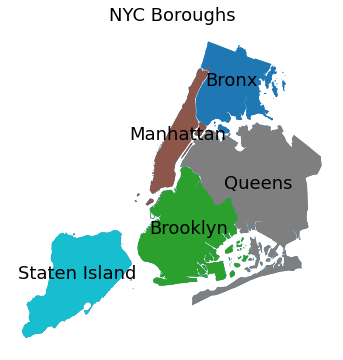

In [3]:
import geopandas as gpd

# use geopandas built in nyc borough map
nyc_boro_map = gpd.read_file(gpd.datasets.get_path('nybb'))
# find centroid of each borough
nyc_boro_map['centroid'] = nyc_boro_map.centroid

# Plot boroughs
fig, ax = plt.subplots(figsize=(14, 6))

nyc_boro_map['geometry'].plot(ax=ax)

nyc_boro_map.plot(column='BoroName', ax=ax)
nyc_boro_map = nyc_boro_map.set_geometry('centroid')

for point in nyc_boro_map.iterrows():
    ax.text(
        point[1]['centroid'].x,
        point[1]['centroid'].y,
        point[1]['BoroName'],
        horizontalalignment='center',
        fontsize=18,
    )

ax.set_title('NYC Boroughs', fontsize=18)
ax.set_axis_off()

plt.show()

How is socioeconomic status distributed throughout the five boroughs?
To answer this, we can use the U.S. Census data on median household income. 

In [4]:
# Can skip
# Use the censusdata API to save

# Save the relevant census geographies
bronx_geo = censusdata.censusgeo([('state', '36'), ('county', '005'), ('tract', '*')])
brooklyn_geo = censusdata.censusgeo([('state', '36'), ('county', '047'), ('tract', '*')])
manhattan_geo = censusdata.censusgeo([('state', '36'), ('county', '061'), ('tract', '*')])
queens_geo = censusdata.censusgeo([('state', '36'), ('county', '081'), ('tract', '*')])
staten_island_geo = censusdata.censusgeo([('state', '36'), ('county', '085'), ('tract', '*')])

# list of variables to download
varlist = ['B19013_001E']

def save_tract(geo):
    df = censusdata.download('acs5', 2014, geo, varlist).reset_index()
    data = df.copy()
    # county (i.e. borough) and census tract are saved within index
    data[['county', 'tract']] = pd.DataFrame(
        np.array([
            [county[1], tract[1]] for (state, county, tract) 
            in data['index'].apply(lambda x: x.params()).tolist()
        ]), index = data.index)

    # rename variable
    data.rename(columns={'B19013_001E': 'med_hh_inc'}, inplace=True)

    return data

bronx_data = save_tract(bronx_geo)
brooklyn_data = save_tract(brooklyn_geo)
queens_data = save_tract(queens_geo)
manhattan_data = save_tract(manhattan_geo)
staten_island_data = save_tract(staten_island_geo)

# concatenate datasets
census_df = pd.concat(
    [bronx_data, brooklyn_data, manhattan_data, queens_data, staten_island_data],
    ignore_index=True
)

# map county codes to borough names
census_df['boro'] = census_df['county'].map({'005': 'Bronx', '047': 'Brooklyn', '061': 'Manhattan', '081': 'Queens','085': 'Staten Island'})

census_df.drop(columns=['index', 'county'], inplace=True)

<AxesSubplot:>

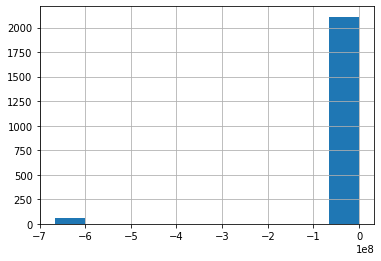

In [5]:
# Saved as strings to preserve leading zeros; not technically necessary
census_df['boro'] = census_df['boro'].astype('string')
census_df['tract'] = census_df['tract'].astype('string')
# print(census_df.info())
# Data cleaning; for instance, plot the relevant variables
census_df['med_hh_inc'].hist()

Clearly we have to decide what to do with these values that are equal to to -6666666. 
To figure out the best solution, let's map which areas are missing median household income data.
This will also help us visualize what the income distribution looks like in NYC.
We'll use a shape file for New York Census, also available through NYC Open Data.

In [6]:
# Can skip
from shapely.geometry import shape
import folium

# Census tract shapefiles
tracts_json = pd.read_json( r'https://data.cityofnewyork.us/resource/i69b-3rdj.json?$limit=5000')
tracts_json['geometry'] = tracts_json['the_geom'].apply(shape)
tracts_shp = gpd.GeoDataFrame(tracts_json).set_geometry('geometry')

# Checks
# check all are integers
# pd.to_numeric(tracts_shp['ct2010'], errors='coerce').notnull().all()
tracts_shp['tract'] = tracts_shp['ct2010'].astype(int).astype('str').str.zfill(6)

tracts_shp.rename(columns={'boro_name': 'boro'}, inplace=True)

census_map = pd.merge(
    tracts_shp, census_df,
    right_on= ['tract', 'boro'],
    left_on= ['tract', 'boro'],
    how='outer',
)

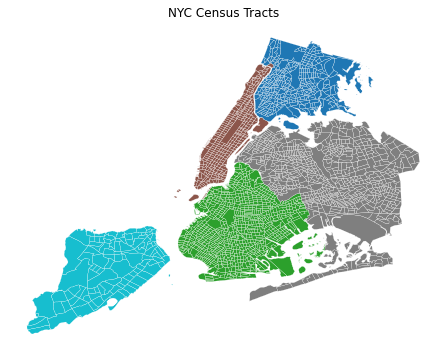

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# borough colors
census_map.plot(column='boro', ax=ax)

census_map['geometry'].plot(
    ax=ax, facecolor='none', 
    edgecolor='white', lw=0.15)

ax.set_title('NYC Census Tracts')
ax.set_axis_off()

plt.show()

# city_map = folium.Map(location=[40.738, -73.98], zoom_start=10)
# for _, r in census_map.iterrows():
# #     #without simplifying the representation of each borough, the map might not be displayed
# #     #sim_geo = gpd.GeoSeries(r['geometry'])
#     sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     geo_j = folium.GeoJson(data=geo_j)
#     my_str = '{name} {ct}'.format(name=r['ntaname'], ct=str(r['ct2010']))
#     folium.Popup(my_str).add_to(geo_j)
#     geo_j.add_to(city_map)

# city_map

Let's now consider which tracts are missing household income. 

In [8]:
# Can skip
census_miss = census_map[census_map['med_hh_inc'] == -666666666]

city_map = folium.Map(location=[40.738, -73.98], zoom_start=11)
for _, r in census_miss.iterrows():
#     #without simplifying the representation of each borough, the map might not be displayed
#     #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    folium.Popup(r['ntaname']).add_to(geo_j)
    geo_j.add_to(city_map)

city_map

It looks like the missing income data are in parks, airports, etc. 
This type of missing data should not impact our analysis about school districts; the NYC public High Schools are generally not located in parks (one exception being a marine high school on Governor's Island).
We can feel somewhat safe dropping them.

In [9]:
# Can skip
census_map.loc[census_map['med_hh_inc'] == -666666666] = np.nan

Now let's consider what the income distribution looks like across New York. 

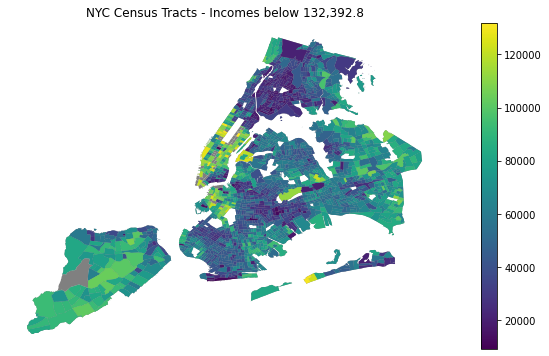

In [10]:
# percentile of income 
# pct = census_map['med_hh_inc'].quantile(1)
pct = census_map['med_hh_inc'].quantile(.98)

fig, ax = plt.subplots(figsize=(14, 6))

census_map['geometry'].plot(ax=ax, color='gray')

census_map.loc[census_map['med_hh_inc'] <= pct].plot(column='med_hh_inc', ax=ax, legend=True)

ax.set_title('NYC Census Tracts - Incomes below {inc:,}'.format(inc=round(pct,2)))
ax.set_axis_off()

plt.show()

## Merging NYC open data with census data

Now we can combine census data with high school location data. 
We know that the [2014 - 2015 DOE High School Directory](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2) has the census tract and address for each high school.
We also have median household income by census tract. Let's see if we can merge these things together.

Note that when census tracts are missing, you can look up the addresses [here](https://geocoding.geo.census.gov/geocoder/geographies/address?form); make sure you adjust your query for the appropriate census vintage!

In [11]:
print('Census tract from NYC Open Data:')
print(hs_info[['dbn', 'census_tract', 'boro']].head())

print('\nCensus tract from ACS data:')
print(census_df[['tract', 'boro']].head())

Census tract from NYC Open Data:
      dbn census_tract       boro
0  27Q260       100802     Queens
1  21K559          306   Brooklyn
2  16K393          291   Brooklyn
3  08X305           16      Bronx
4  03M485          151  Manhattan

Census tract from ACS data:
    tract   boro
0  035100  Bronx
1  036700  Bronx
2  038100  Bronx
3  038800  Bronx
4  039700  Bronx


A problem: the census tract in the ACS data is 6-digits, and the census tract in NYC Open data has a variable number of digits.
In general, you should be careful when working with census tracts, and carefully check whether your merges are working. 

In a different jupyter notebook in this folder ([Census tract lookup](https://github.com/tara-sullivan/nyc_high_school_outcomes/blob/master/Census%20tract%20lookup.ipynb)), I do my best to match the census tract in the NYC Open Data to the ACS data.
I first come up with a guess for what the 6-digit census tract should be, given what I know about census data.
I then attempt to lookup the census tract for each school by its address using the [Census Geocoder](https://geocoding.geo.census.gov/geocoder/); the [Census Geocoder API](https://census-geocoder.readthedocs.io/en/latest/) makes this easy (this takes about 10-15 minutes to run).
I check that my guess matches the looked up census tract, and then investigate the missing values or mismatches. 
To keep things short in this presentation, I saved the results as a CSV.

In [12]:
hs_tract = pd.read_csv('dbn_tract_lookup.csv', dtype=str)

hs_tract.drop(columns=['tract_lookup', 'tract_guess'], inplace=True)

dbn_census_df = pd.merge(hs_tract, census_df, how='left', on=['tract', 'boro'])

We can now look at all of the census tracts that have high schools!

In [13]:
dbn_shp = pd.merge(tracts_shp, dbn_census_df, on=['tract', 'boro'])
dbn_shp.loc[dbn_shp['med_hh_inc'] == -666666666] = np.nan

city_map = folium.Map(location=[40.738, -73.98], zoom_start=11)
for _, r in dbn_shp.iterrows():
#     #without simplifying the representation of each borough, the map might not be displayed
#     #sim_geo = gpd.GeoSeries(r['geometry'])
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    folium.Popup(r['ntaname']).add_to(geo_j)
    geo_j.add_to(city_map)

city_map

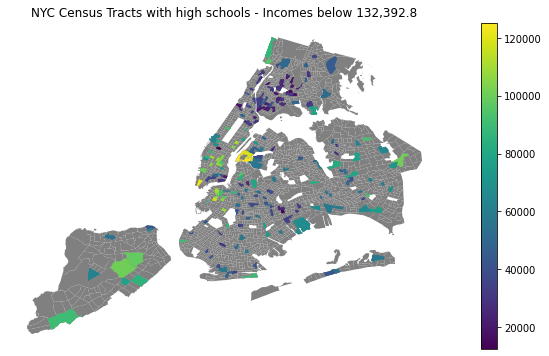

In [14]:
pct = census_map['med_hh_inc'].quantile(.98)

fig, ax = plt.subplots(figsize=(14, 6))

census_map['geometry'].plot(ax=ax, color='gray')
dbn_shp['geometry'].plot(ax=ax, color='gray')

dbn_shp.loc[
    (dbn_shp['med_hh_inc'] <= pct)].plot(column='med_hh_inc', ax=ax, legend=True)

ax.set_title('NYC Census Tracts with high schools - Incomes below {inc:,}'.format(inc=round(pct,2)))
ax.set_axis_off()

plt.show()

# High school data

We already accessed High School directory information from 2014-15 above.
We can access some details about high school students' income and the overall high school performance using the [2014-2015 School Quality Reports for High Schools](https://data.cityofnewyork.us/Education/2014-2015-School-Quality-Reports-Results-For-High-/vrfr-9k4d).
<!-- We can also access [High School Performance data](https://data.cityofnewyork.us/Education/2016-DOE-High-School-Performance-Directory/qvir-knu3). -->
Let's start by looking at some data on student economic variables.

In [15]:
hs_summ = pd.read_excel(
    '2014_2015_HS_SQR_Results_2016_01_07.xlsx', engine='openpyxl',
    sheet_name='Summary',
    skiprows=0, header=1)

for col in ['DBN', 'School Name', 'School Type']:
    hs_summ[col] = hs_summ[col].astype('string')

# hs_summ.info()

brooklyn_geo

censusgeo((('state', '36'), ('county', '047'), ('tract', '*')))

The dataset contains school level estimates of an Economic Needs Index ([Source](https://www.schools.nyc.gov/docs/default-source/default-document-library/diversity-in-new-york-city-public-schools-english)):

    A school’s Economic Need is defined by its Economic Need Index (ENI), which determines the likelihood that students at the school are in poverty. The ENI is calculated as follows: If the student is HRA-eligible or living in temporary housing, the student’s Economic Need Value is 1.0. For high school students, if the student has a home language other than English and entered the NYC DOE for the first time within the last four years, the student’s ENI value is 1.0.  Otherwise, the student’s Economic Need Value Is based on the percentage of families (with school-age children) in the student’s census tract whose income is below the poverty level, as estimated by the American Community Survey 5-Year Estimate. 
    
Note that the Economic Need Index is estimated from the same census data we used above.
What measurement issues might arise from using census data to estimate student need?

array([[<AxesSubplot:title={'center':'Economic Need Index'}>,
        <AxesSubplot:title={'center':'Percent in Temp Housing - 4yr'}>],
       [<AxesSubplot:title={'center':'Percent HRA Eligible'}>,
        <AxesSubplot:>]], dtype=object)

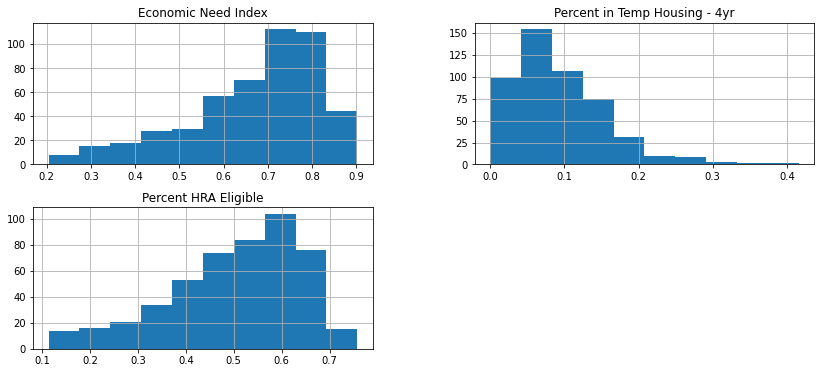

In [16]:
hs_econ = hs_summ[['DBN', 'School Name', 
                   'Economic Need Index', 'Percent in Temp Housing - 4yr',
                   'Percent HRA Eligible']]

hs_econ.hist(figsize=(14, 6))

**Measurement question**: What issues could you see with using the above variables for proxying student SES?

Let's now consider variables about student performance.

array([[<AxesSubplot:title={'center':'CRI (Percentage of 4 year Cohort)'}>,
        <AxesSubplot:title={'center':'Percentage of 4-year Cohort Taking SAT Math'}>]],
      dtype=object)

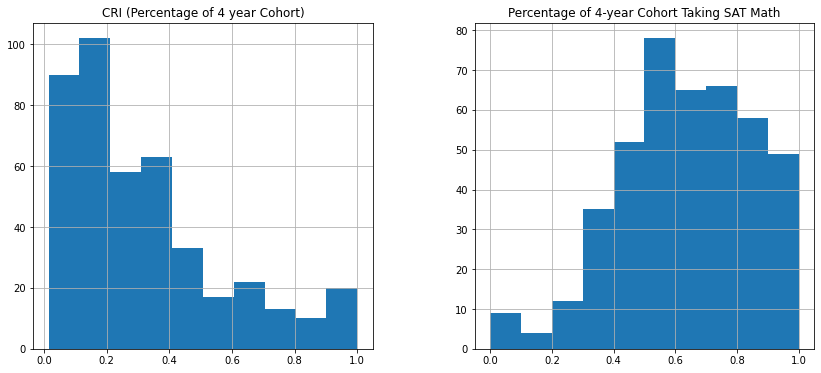

In [17]:
# Convert to pandas DataFrame
hs_perform = pd.read_excel(
    '2014_2015_HS_SQR_Results_2016_01_07.xlsx', engine='openpyxl',
    sheet_name='Additional Info',
    skiprows=0, header=1)

for col in ['DBN', 'School Name']:
    hs_perform[col] = hs_perform[col].astype('string')
hs_perform.rename(columns={'DBN': 'dbn'}, inplace=True)
    
hs_perform[[
#     'Percentage at college ready threshold Regents Algebra',
    'CRI (Percentage of 4 year Cohort)',
    'Percentage of 4-year Cohort Taking SAT Math']].hist(figsize=(14,6))

So far we have shown we have access to NYC DOE data on:

* Academic performance
* Student economic conditions
* School location and characteristics

Further, we know we can merge this data with Census information for details about the surrounding neighborhood.
We are now prepared to investigate whether some sort of inequity exists between those low-SES students, and high-SES students. 

<AxesSubplot:xlabel='med_hh_inc', ylabel='Percentage of 4-year Cohort Taking SAT Math'>

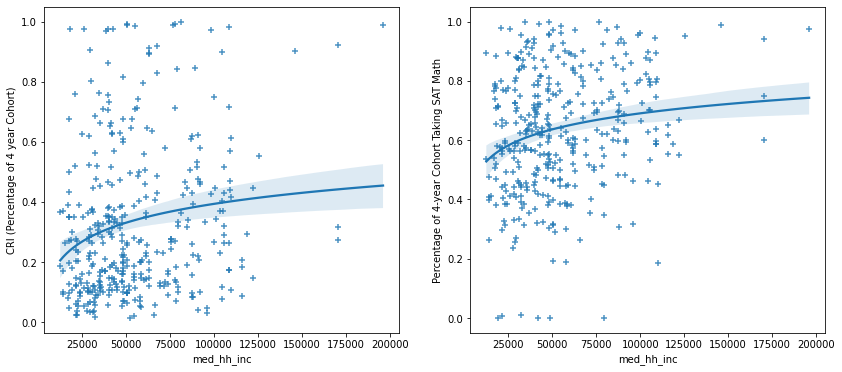

In [18]:
merge_df = pd.merge(
    dbn_census_df,
        hs_perform[[
        'dbn',
        'CRI (Percentage of 4 year Cohort)',
        'Percentage of 4-year Cohort Taking SAT Math']],
    on='dbn',
)
merge_df.loc[merge_df['med_hh_inc'] == -666666666] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.regplot(
    x=merge_df['med_hh_inc'],
    y=merge_df['CRI (Percentage of 4 year Cohort)'],
    marker="+", ax=ax[0], logx=True)

sns.regplot(
    x=merge_df['med_hh_inc'],
    y=merge_df['Percentage of 4-year Cohort Taking SAT Math'],
    marker="+", ax=ax[1], logx=True)

In [19]:
from statsmodels.regression.linear_model import OLS

bool_idx = (merge_df['med_hh_inc'].notna()) &(merge_df['Percentage of 4-year Cohort Taking SAT Math'].notna())

mod = OLS(
    merge_df['med_hh_inc'].loc[bool_idx],
    merge_df['Percentage of 4-year Cohort Taking SAT Math'].loc[bool_idx],
)
results = mod.fit()
results.summary()

bool_idx = (merge_df['med_hh_inc'].notna()) &(merge_df['CRI (Percentage of 4 year Cohort)'].notna())

mod = OLS(
    merge_df['med_hh_inc'].loc[bool_idx],
    merge_df['CRI (Percentage of 4 year Cohort)'].loc[bool_idx],
)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             med_hh_inc   R-squared (uncentered):                   0.577
Model:                            OLS   Adj. R-squared (uncentered):              0.576
Method:                 Least Squares   F-statistic:                              513.6
Date:                Thu, 14 Apr 2022   Prob (F-statistic):                    2.30e-72
Time:                        11:25:17   Log-Likelihood:                         -4549.2
No. Observations:                 378   AIC:                                      9100.
Df Residuals:                     377   BIC:                                      9104.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
CRI (Percentage of 4 year Cohort)  1.158e+05   5109.142     22.662      0.000    1.06e+05    1.26e+05
==============================================================================
Omnibus:                        2.445   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.294   Jarque-Bera (JB):                2.428
Skew:                          -0.069   Prob(JB):                        0.297
Kurtosis:                       3.368   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
!conda list pandas
!conda list numpy
!conda list sodapy
!conda list requests
!conda list geopandas
!conda list openpyxl
!conda list censusgeocode
!conda list matplotlib
!conda list seaborn
!conda list statsmodels

# packages in environment at /Users/tarasullivan/opt/miniconda3/envs/nyc_doe:
#
# Name                    Version                   Build  Channel
geopandas                 0.10.2                   pypi_0    pypi
pandas                    1.4.2                    pypi_0    pypi
# packages in environment at /Users/tarasullivan/opt/miniconda3/envs/nyc_doe:
#
# Name                    Version                   Build  Channel
numpy                     1.22.3                   pypi_0    pypi
# packages in environment at /Users/tarasullivan/opt/miniconda3/envs/nyc_doe:
#
# Name                    Version                   Build  Channel
sodapy                    2.1.0                    pypi_0    pypi
# packages in environment at /Users/tarasullivan/opt/miniconda3/envs/nyc_doe:
#
# Name                    Version                   Build  Channel
requests                  2.27.1                   pypi_0    pypi
requests-toolbelt         0.9.1                    pypi_0    pypi
# packages in en